In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import random
import missingno as msno
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
sns.set()

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
file_path = r'C:\Users\zara8\Capstone_project_2\Raw_Data\amz_us_price_prediction_dataset.csv'
raw_df=pd.read_csv(file_path, index_col=["uid"])
raw_df.head()

,asin,title,stars,reviews,price,category,isBestSeller,boughtInLastMonth
uid,,,,,,,,
1,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",4.5,0,139.99,Suitcases,False,2000
2,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,4.5,0,169.99,Suitcases,False,1000
3,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,4.6,0,365.49,Suitcases,False,300
4,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,4.6,0,291.59,Suitcases,False,400
5,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,4.5,0,174.99,Suitcases,False,400


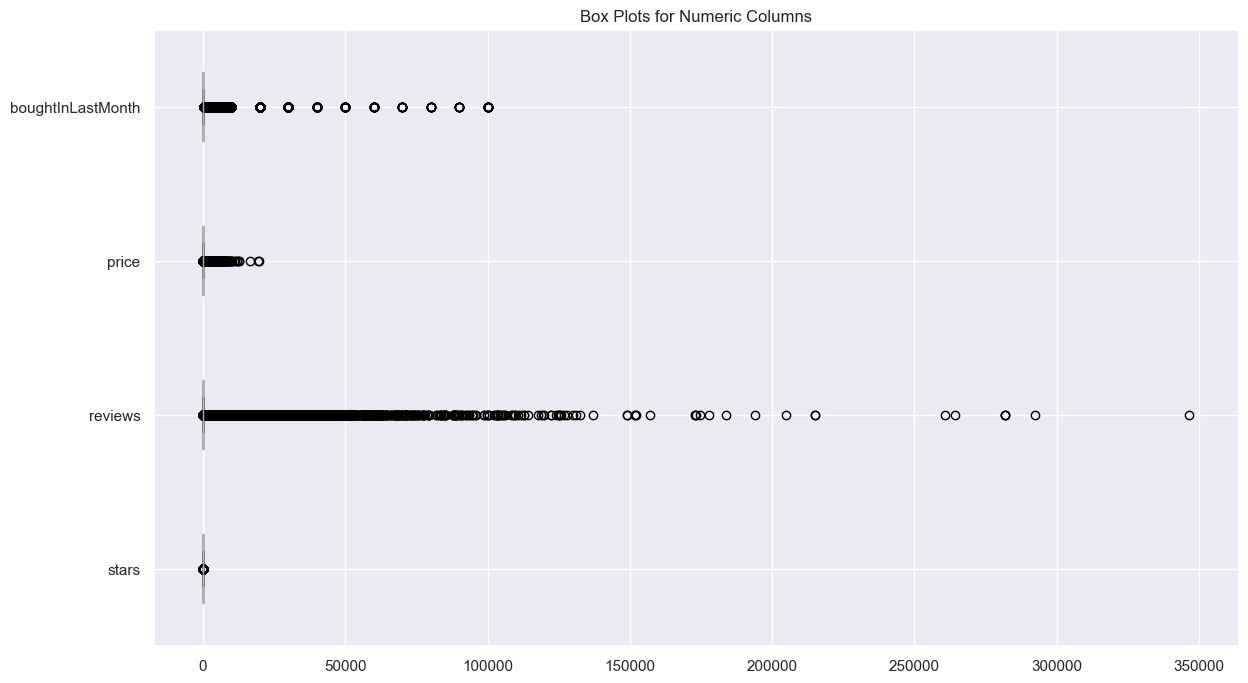

In [4]:
# Finding outliers
numeric_columns = ['stars', 'reviews', 'price', 'boughtInLastMonth']


plt.figure(figsize=(14, 8))
raw_df[numeric_columns].boxplot(sym='o', vert=False)
plt.title('Box Plots for Numeric Columns')
plt.show()

In [5]:
# rows with null values in the 'title' column
print(raw_df[raw_df['title'].isnull()])

               asin title  stars  reviews  price  category  isBestSeller  \
uid                                                                        
1819752  B00758A9CE   NaN    5.0        0  33.08  Car Care         False   

         boughtInLastMonth  
uid                         
1819752                  0  


There is only one row in the dataset where the 'title' column has a null value. All other columns in that row have valid data. This row is uid= '1819752'. Keep it for now

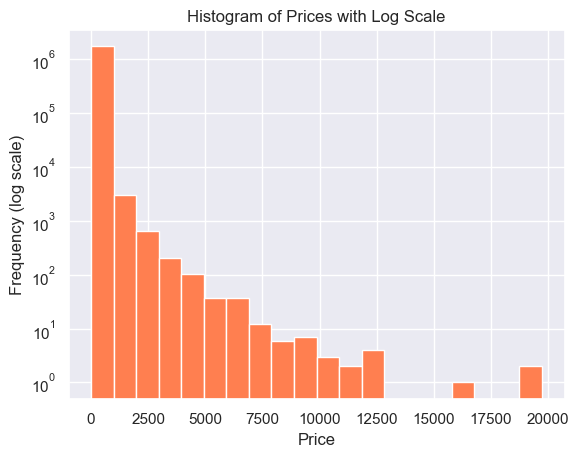

In [6]:
#histogram with log scale on the y-axis
plt.hist(raw_df['price'], bins=20, color='coral')
plt.yscale('log')  # Use log scale on the y-axis
plt.xlabel('Price')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of Prices with Log Scale')
plt.show()

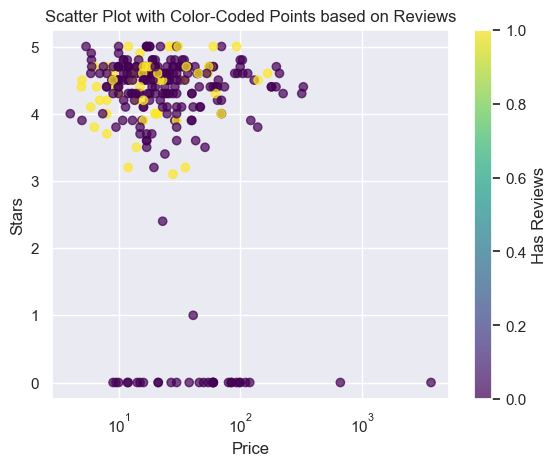

In [7]:
raw_df["has_reviews"] = raw_df["reviews"].apply(lambda x: 1 if x > 1 else 0)

# Sample 300 data points
sampled_df = raw_df.sample(n=300, random_state=42)

plt.scatter(sampled_df['price'], sampled_df['stars'], c=sampled_df['has_reviews'], cmap='viridis', alpha=0.7)
plt.xscale('log')  
plt.xlabel('Price')
plt.ylabel('Stars')
plt.title('Scatter Plot with Color-Coded Points based on Reviews')


cbar = plt.colorbar()
cbar.set_label('Has Reviews')
plt.show()

In [8]:
# How many categories?
category_counts = raw_df['category'].value_counts().to_dict()

#  a new DataFrame 'categories' from the dictionary
categories = pd.DataFrame(list(category_counts.items()), columns=['category', 'count'])

print(categories)

                                           category  count
0                               Games & Accessories  32449
1                                   Girls' Clothing  28688
2                                      Toys & Games  27624
3                            Consoles & Accessories  25295
4                                    Boys' Clothing  24971
..                                              ...    ...
231  Smart Home Thermostats - Compatibility Checker    131
232                    Smart Home: Vacuums and Mops    127
233                   Smart Home: New Smart Devices     95
234                     Smart Home: Lawn and Garden     79
235           Smart Home: Voice Assistants and Hubs     51

[236 rows x 2 columns]


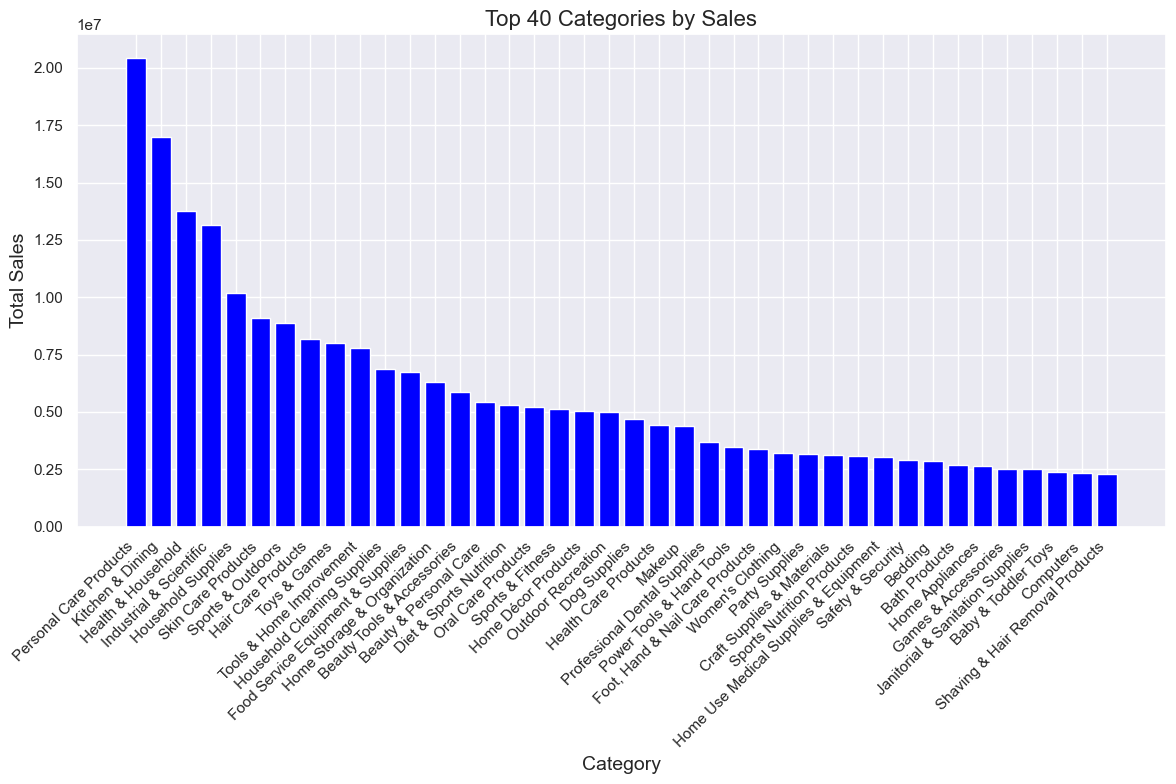

In [9]:
#Top 40  categories by  Sales
top_categories_df = raw_df[['category', 'boughtInLastMonth']].groupby(by=['category']).sum().reset_index().sort_values(by='boughtInLastMonth', ascending=False).head(n=40)

plt.figure(figsize=(12, 8))
plt.bar(top_categories_df['category'], top_categories_df['boughtInLastMonth'], color='blue')
plt.xlabel('Category',fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.title('Top 40 Categories by Sales', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  
plt.show()

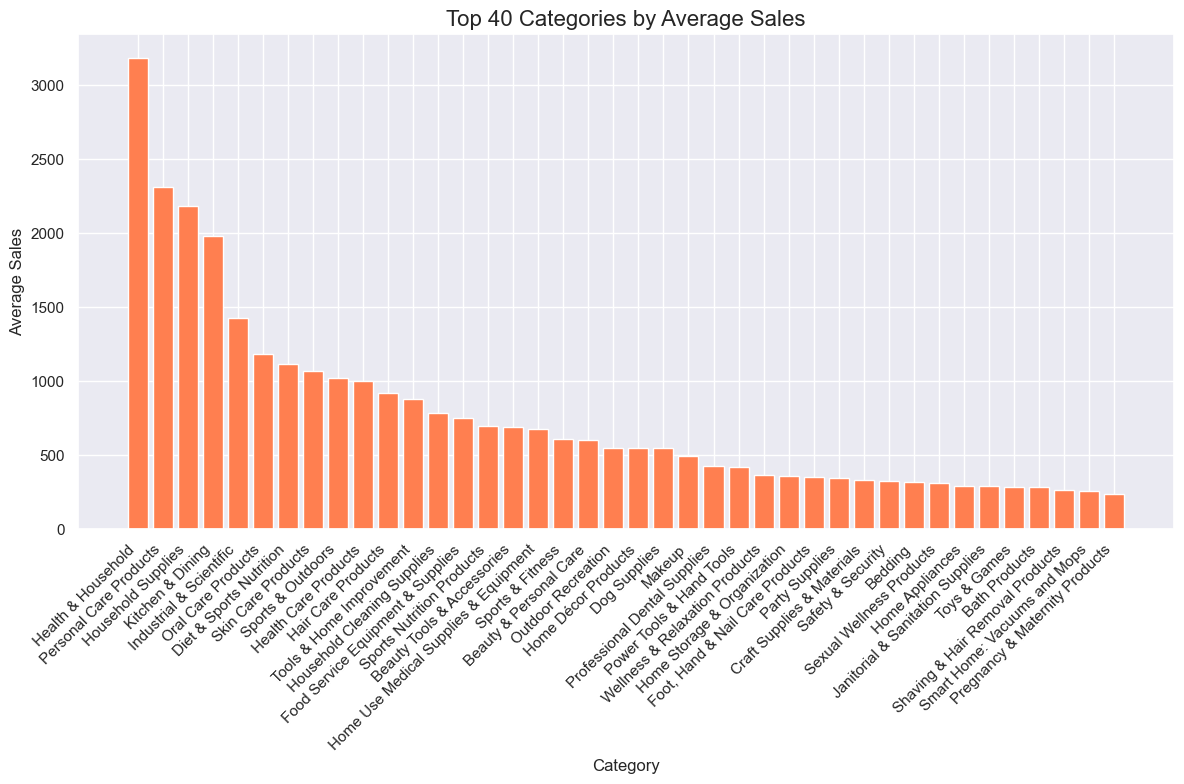

In [10]:
#Top 40  categories by average sales
average_sales_by_category = raw_df.groupby('category')['boughtInLastMonth'].mean().reset_index()
top_categories = average_sales_by_category.sort_values(by='boughtInLastMonth', ascending=False).head(n=40)

plt.figure(figsize=(12, 8))
plt.bar(top_categories['category'], top_categories['boughtInLastMonth'], color='coral')
plt.xlabel('Category')
plt.ylabel('Average Sales')
plt.title(f'Top 40 Categories by Average Sales',fontsize=16)
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()


In [11]:

raw_df.columns

Index(['asin', 'title', 'stars', 'reviews', 'price', 'category',
       'isBestSeller', 'boughtInLastMonth', 'has_reviews'],
      dtype='object')

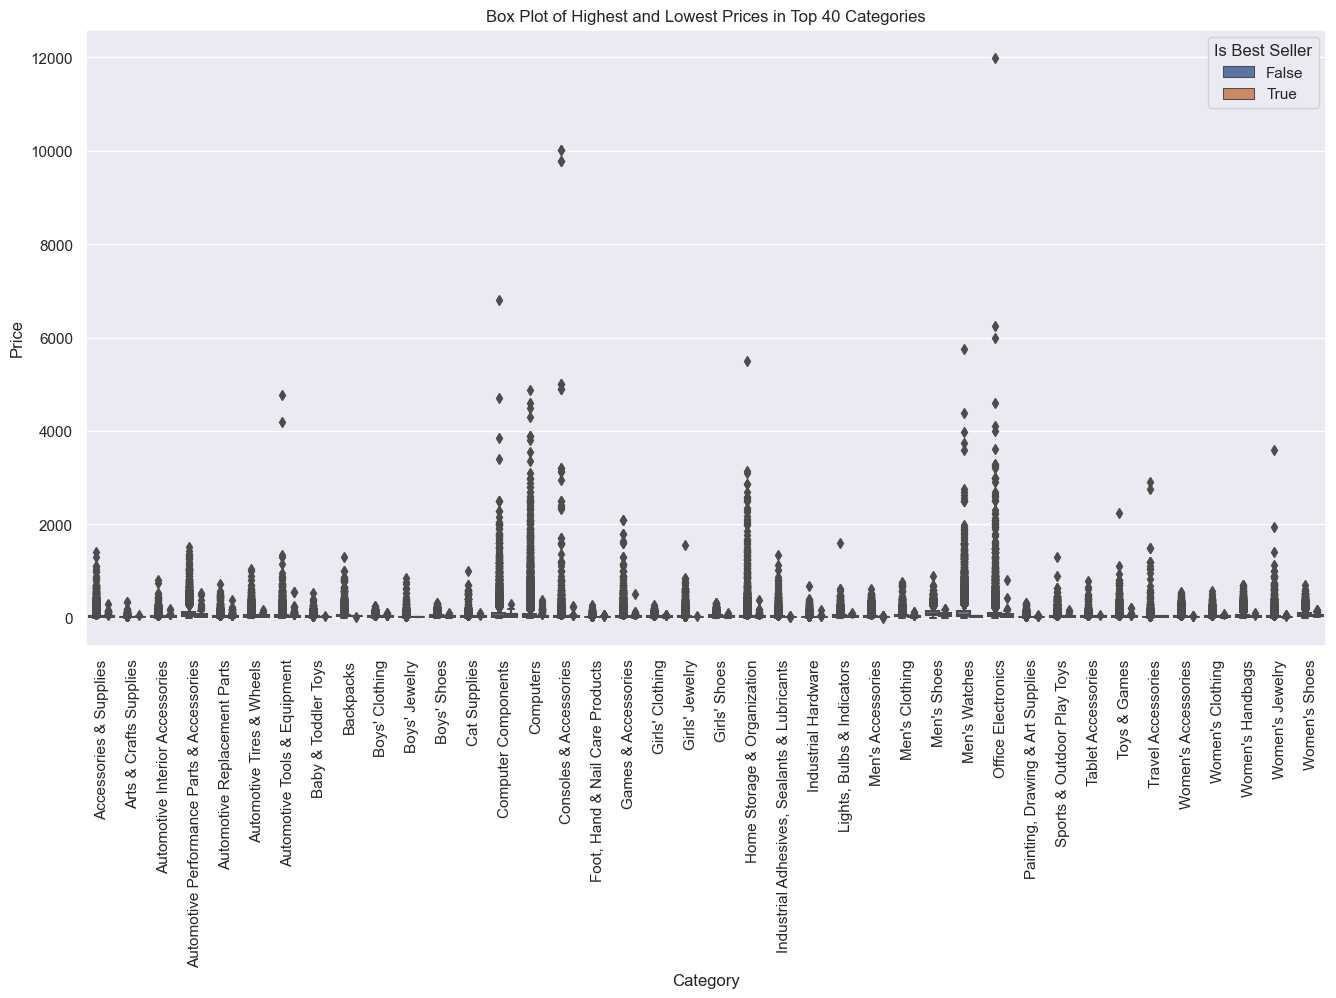

In [12]:

# the top 40 categories by item count
top_categories = raw_df['category'].value_counts().nlargest(40).index

# Filtering the DataFrame for the top categories
filtered_df = raw_df[raw_df['category'].isin(top_categories)]

# Sort the DataFrame by price within each category
sorted_df = filtered_df.sort_values(by=['category', 'price'])


plt.figure(figsize=(16, 8))
sns.boxplot(x='category', y='price', data=sorted_df, hue='isBestSeller', width=0.8)
plt.xlabel('Category')
plt.ylabel('Price')
plt.title('Box Plot of Highest and Lowest Prices in Top 40 Categories')
plt.xticks(rotation=90)
plt.legend(title='Is Best Seller', bbox_to_anchor=(1, 1))
plt.show()



In [13]:
# for curiosity
selected_category = 'Kitchen & Dining'

kitchen_dining_df = raw_df[raw_df['category'] == selected_category]

# Identify rows with the same title but different prices
duplicate_titles_df = kitchen_dining_df[kitchen_dining_df.duplicated('title', keep=False)]

result_df = duplicate_titles_df[['title', 'price']]

print(result_df)



                                                     title  price
uid                                                              
1392115  2 Pack Under Sink Organizer, 2 Tier Bathroom C...  28.79
1441750  ZeroWater 10-Cup Ready-Pour 5-Stage Water Filt...  34.99
1442369  2 Pack Under Sink Organizer, 2 Tier Bathroom C...  28.99
1442994  Dirty Clean Dishwasher Magnet,Dishwasher Magne...   3.99
1444008  Dirty Clean Dishwasher Magnet,Dishwasher Magne...   4.99
1444557  Paper Towel Holder, Self Adhesive or Screw Mou...   7.99
1444714  Stainless Steel Snack Containers for Kids | Ea...  17.99
1445093  TILUCK measuring cups and magnetic measuring s...  26.99
1446104  TILUCK measuring cups and magnetic measuring s...  19.99
1447204  Stainless Steel Snack Containers for Kids | Ea...  23.99
1447311  Paper Towel Holder, Self Adhesive or Screw Mou...   6.99
1447441  ZeroWater 10-Cup Ready-Pour 5-Stage Water Filt...  29.99


In [14]:
raw_df.loc[1392115]

asin                                                        B0BTVDGHZT
title                2 Pack Under Sink Organizer, 2 Tier Bathroom C...
stars                                                              4.4
reviews                                                              0
price                                                            28.79
category                                              Kitchen & Dining
isBestSeller                                                     False
boughtInLastMonth                                                  500
has_reviews                                                          0
Name: 1392115, dtype: object

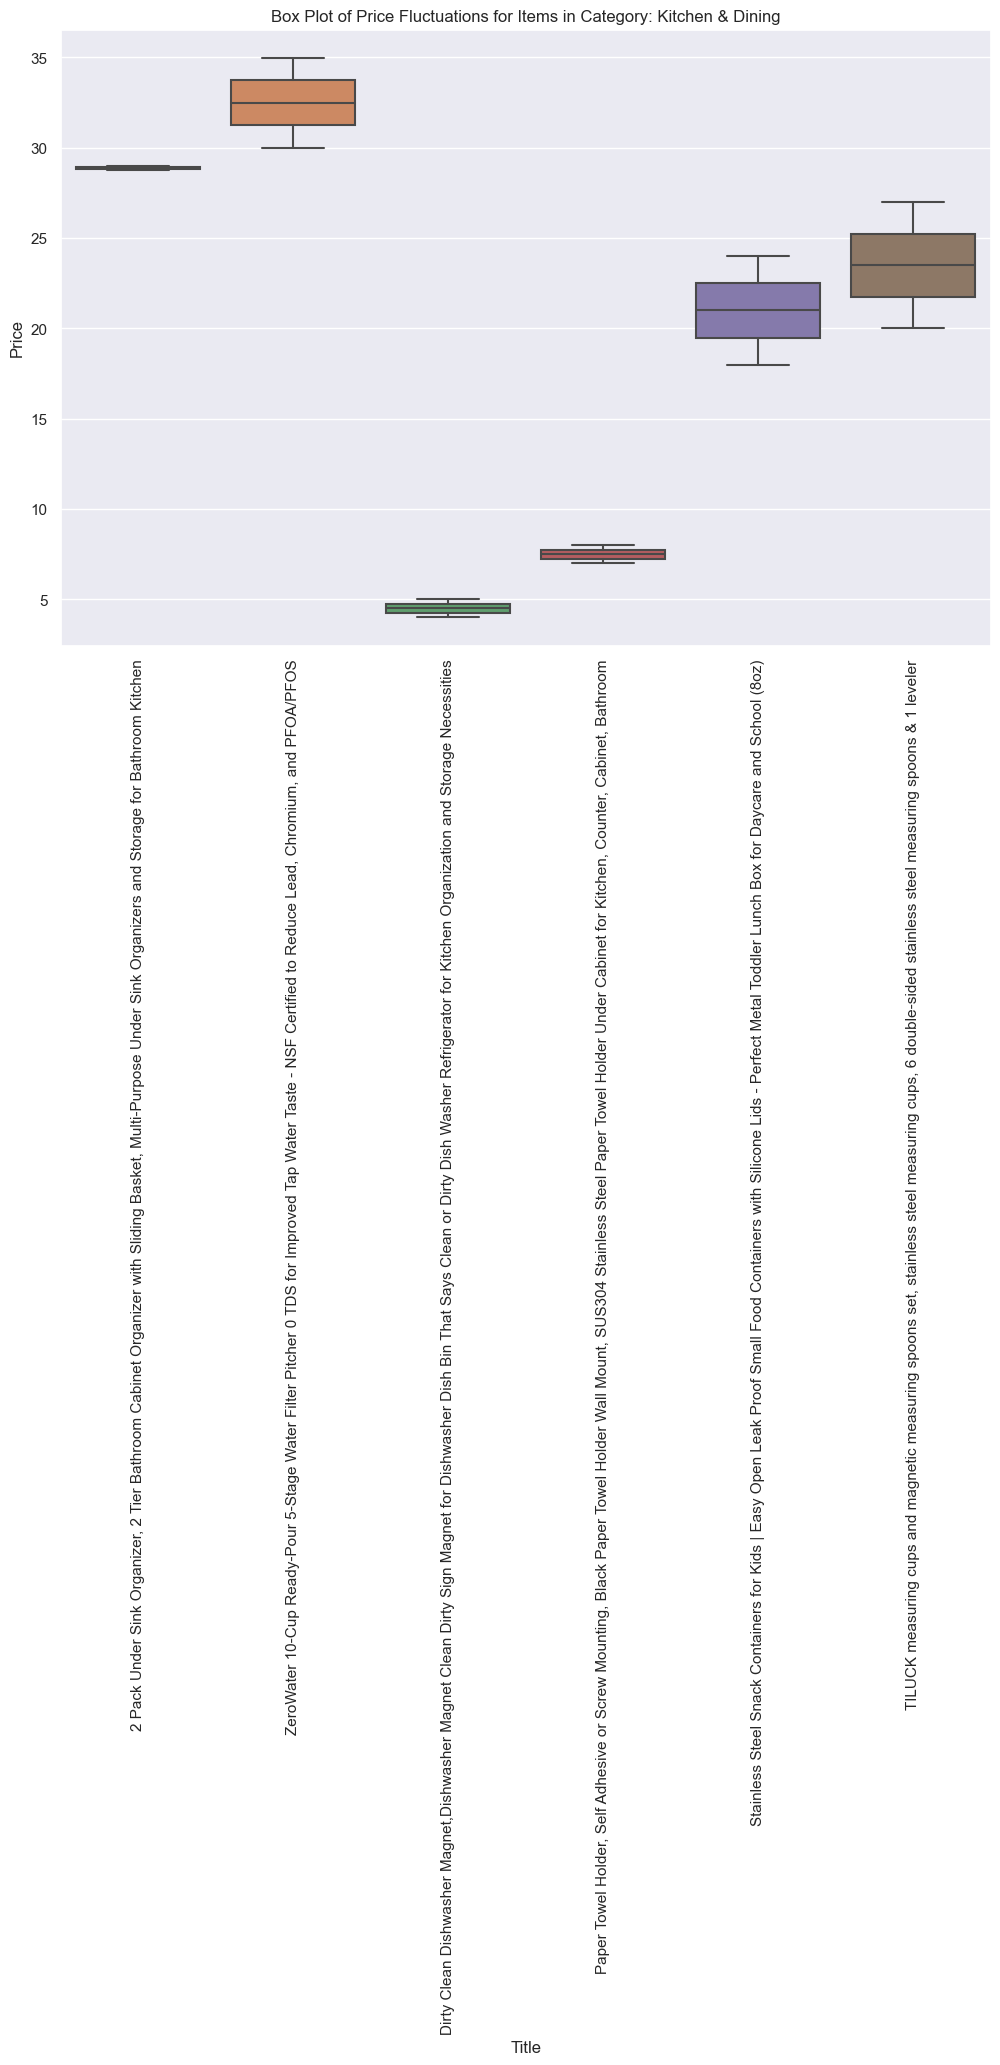

In [15]:
#for curiosity
selected_category = 'Kitchen & Dining'

# Filtering the DataFrame for the selected category
kitchen_dining_df = raw_df[raw_df['category'] == selected_category]

# Identify rows with the same title but different prices
duplicate_titles_df = kitchen_dining_df[kitchen_dining_df.duplicated('title', keep=False)]

plt.figure(figsize=(12, 8))
sns.boxplot(x='title', y='price', data=duplicate_titles_df)
plt.xlabel('Title')
plt.ylabel('Price')
plt.title(f'Box Plot of Price Fluctuations for Items in Category: {selected_category}')
plt.xticks(rotation=90)
plt.show()


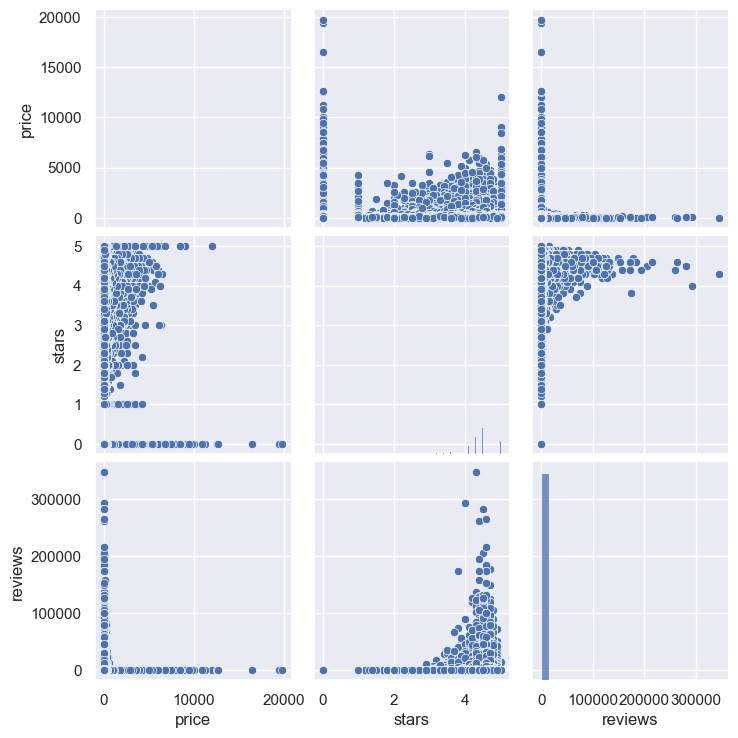

In [16]:
sns.pairplot(raw_df[['price', 'stars', 'reviews']])
plt.show()

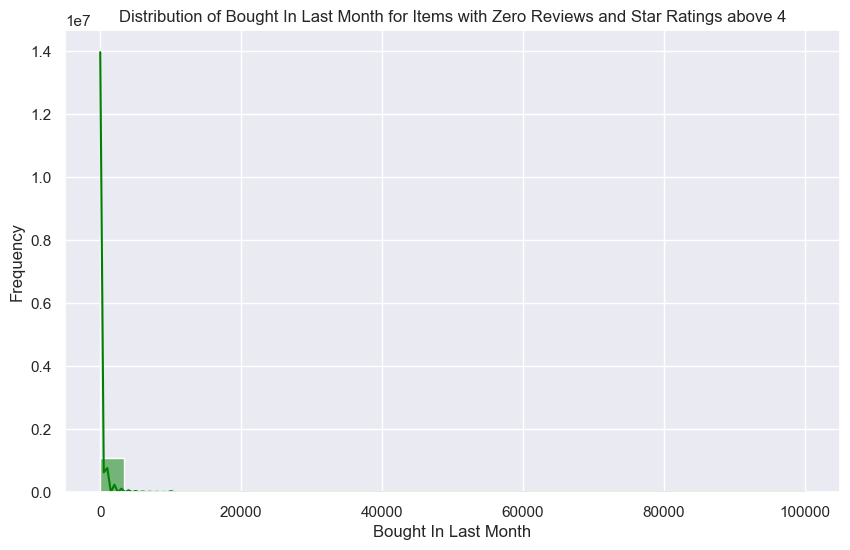

Number of items with zero reviews and star ratings above 4: 1102724


In [17]:
# items with zero reviews and star ratings above 4
filtered_df = raw_df[(raw_df['reviews'] == 0) & (raw_df['stars'] > 4)]

# The distribution of 'boughtInLastMonth' for items with zero reviews and star ratings above 4
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['boughtInLastMonth'], bins=30, kde=True, color='green')
plt.xlabel('Bought In Last Month')
plt.ylabel('Frequency')
plt.title('Distribution of Bought In Last Month for Items with Zero Reviews and Star Ratings above 4')
plt.show()

print(f'Number of items with zero reviews and star ratings above 4: {len(filtered_df)}')


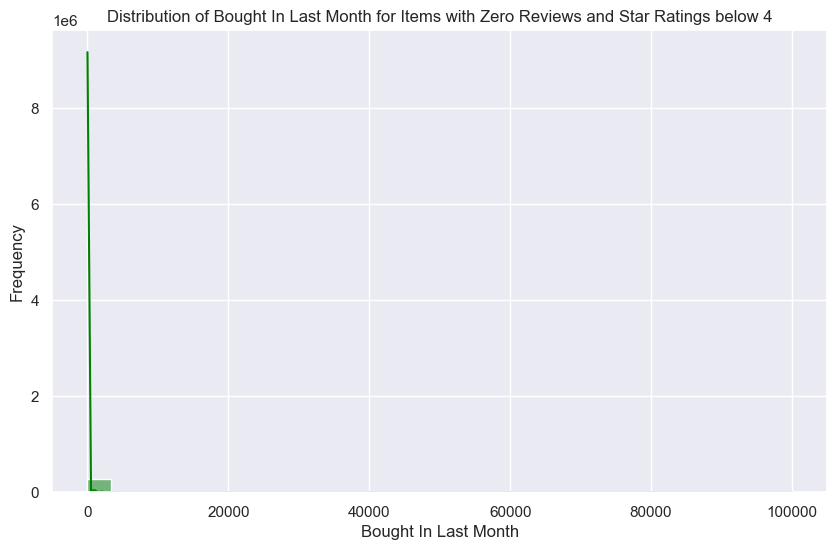

Number of items with zero reviews and star ratings below 4: 264486


In [18]:
# for curiosity
# Filtering the DataFrame for items with zero reviews and star ratings below 4
filtered_df = raw_df[(raw_df['reviews'] == 0) & (raw_df['stars'] < 4)]

# Plot the distribution of 'boughtInLastMonth' for items with zero reviews and star ratings below 4
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['boughtInLastMonth'], bins=30, kde=True, color='green')
plt.xlabel('Bought In Last Month')
plt.ylabel('Frequency')
plt.title('Distribution of Bought In Last Month for Items with Zero Reviews and Star Ratings below 4')
plt.show()

# Print the number of items meeting the condition
print(f'Number of items with zero reviews and star ratings below 4: {len(filtered_df)}')


In [19]:
max_reviews_items_by_category = raw_df.loc[raw_df.groupby('category')['reviews'].idxmax()]

columns_to_extract = ['category', 'title', 'reviews', 'stars', 'boughtInLastMonth']
items_with_highest_reviews_by_category = max_reviews_items_by_category[columns_to_extract]

#  a new DataFrame with the information
highest_reviews_by_category_df = pd.DataFrame(items_with_highest_reviews_by_category)

print(highest_reviews_by_category_df.head(4).T)




uid                                                          1651749  \
category                               Abrasive & Finishing Products   
title              Homax 10120000 Steel Wool, 12 pad, Grade #0000...   
reviews                                                        30390   
stars                                                            4.7   
boughtInLastMonth                                                  0   

uid                                                          474678   \
category                                      Accessories & Supplies   
title              SanDisk 128GB Extreme microSDXC UHS-I Memory C...   
reviews                                                            0   
stars                                                            4.8   
boughtInLastMonth                                                  0   

uid                                                          68061    \
category                             Additive Manufacturing Pr

In [20]:

unique_asin_count = len(raw_df['asin'].unique())

asin_counts = raw_df['asin'].value_counts()
print("Number of unique values in 'asin' column:", unique_asin_count)
print("\nNumber of occurrences for each 'asin' value:")
print(asin_counts)


Number of unique values in 'asin' column: 1426337

Number of occurrences for each 'asin' value:
asin
B001T8UD4U    10
B085W1KZ3N    10
B0017DF9U0    10
B07S9FMPD2    10
B06WP1XHBH    10
              ..
B09FYTWNF1     1
B09NQWJ98B     1
B0BHX9Q8Y9     1
B09T34SCHX     1
B07GH67QC8     1
Name: count, Length: 1426337, dtype: int64


In [21]:
# Group by 'asin' and 'category' and count unique prices
price_counts = raw_df.groupby(['asin', 'category'])['price'].nunique()

# Filtering values with more than one unique price
different_prices_asin = price_counts[price_counts > 1].reset_index()['asin']

print(different_prices_asin)


0      B000HHHC3E
1      B000N56U8I
2      B000NO9HK2
3      B000TUE2TQ
4      B000Y0BBCM
          ...    
464    B0CGDV947H
465    B0CGL3YDPH
466    B0CHF1QT4Y
467    B0CHF23GPB
468    B0CJ4Z7QPB
Name: asin, Length: 469, dtype: object


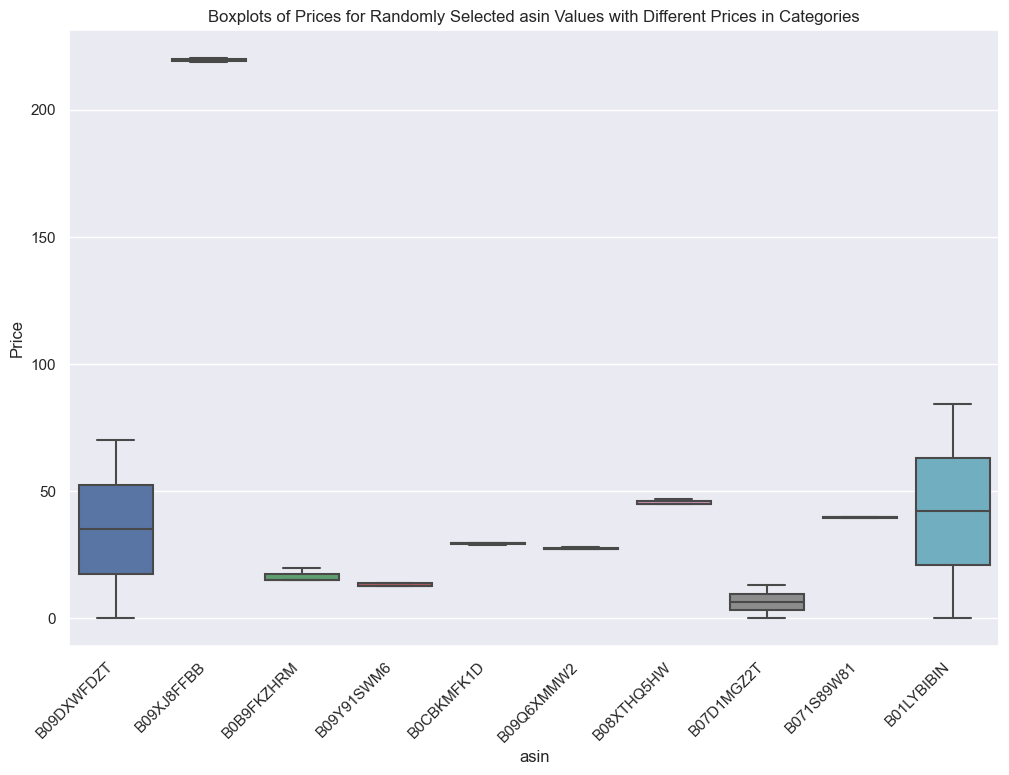

In [22]:

random_selected_asin_values = random.sample(different_prices_asin.tolist(), 10)

# Filtering rows for the randomly selected 'asin' values
random_selected_rows = raw_df[raw_df['asin'].isin(random_selected_asin_values)]

plt.figure(figsize=(12, 8))
sns.boxplot(x='asin', y='price', data=random_selected_rows)
plt.xticks(rotation=45, ha='right')
plt.xlabel('asin')
plt.ylabel('Price')
plt.title('Boxplots of Prices for Randomly Selected asin Values with Different Prices in Categories')
plt.show()


In [23]:
#  median price for each unique 'asin' value
median_prices = raw_df.groupby('asin')['price'].median()

#a  new column 'median_price' in the original DataFrame
raw_df['median_price'] = raw_df['asin'].map(median_prices)
print(raw_df[['asin', 'price', 'median_price']].head())


           asin   price  median_price
uid                                  
1    B014TMV5YE  139.99        139.99
2    B07GDLCQXV  169.99        169.99
3    B07XSCCZYG  365.49        365.49
4    B08MVFKGJM  291.59        291.59
5    B01DJLKZBA  174.99        174.99


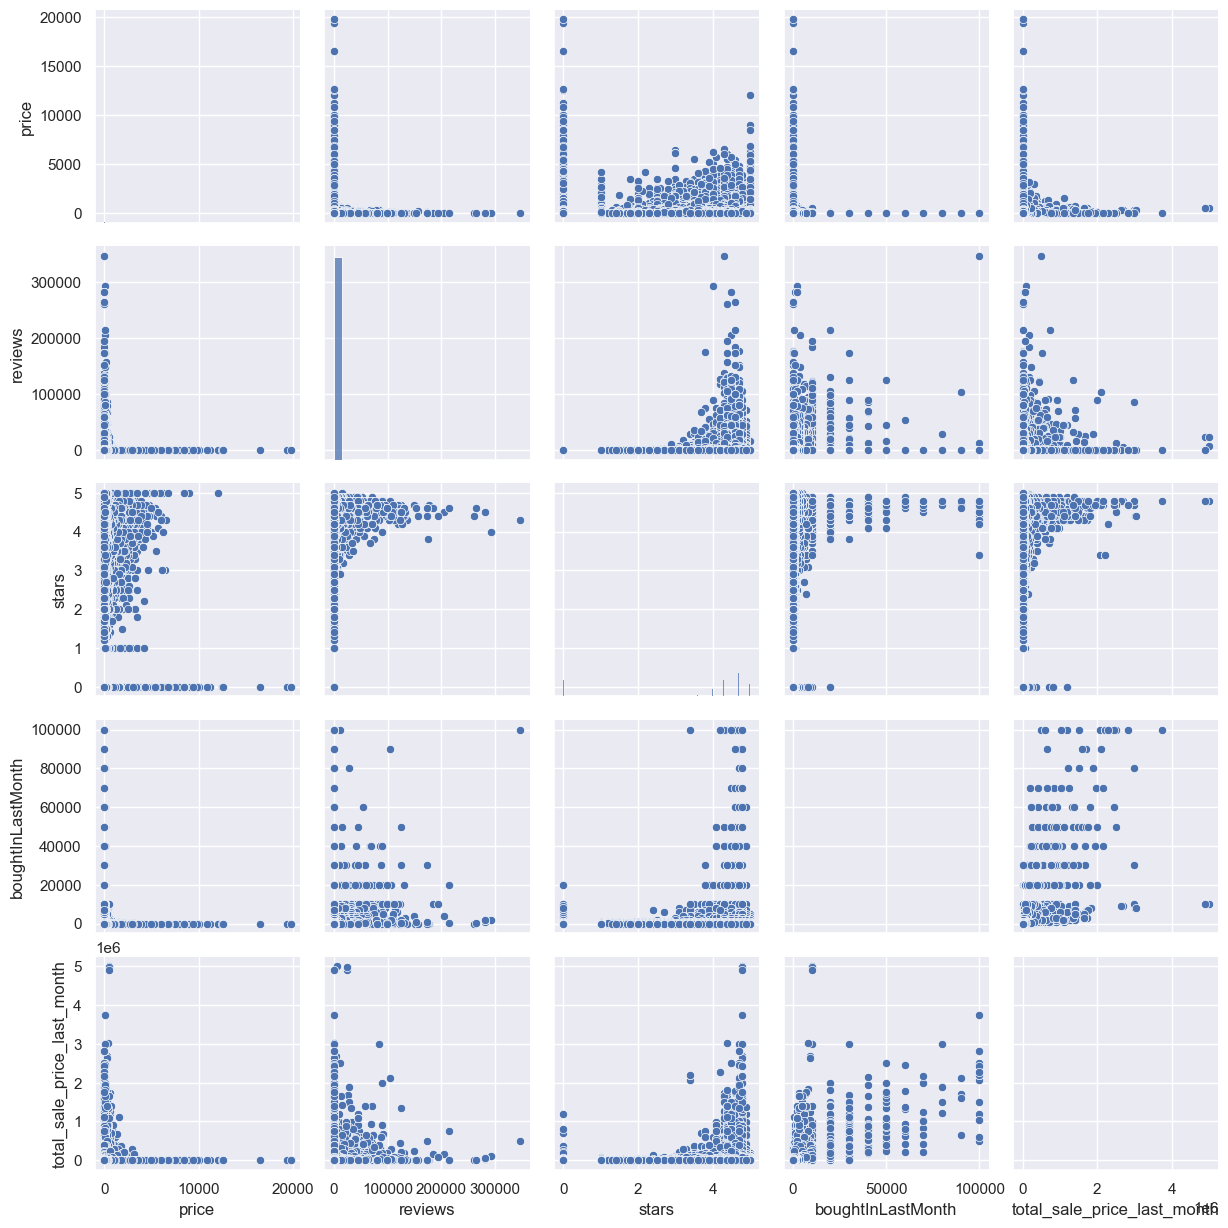

In [24]:
#  a new column 'total_sale_price_last_month' for estimated revenue
raw_df['total_sale_price_last_month'] = raw_df['price'] * raw_df['boughtInLastMonth']
sns.pairplot(raw_df[['price', 'reviews', 'stars', 'boughtInLastMonth', 'total_sale_price_last_month']])
plt.show()


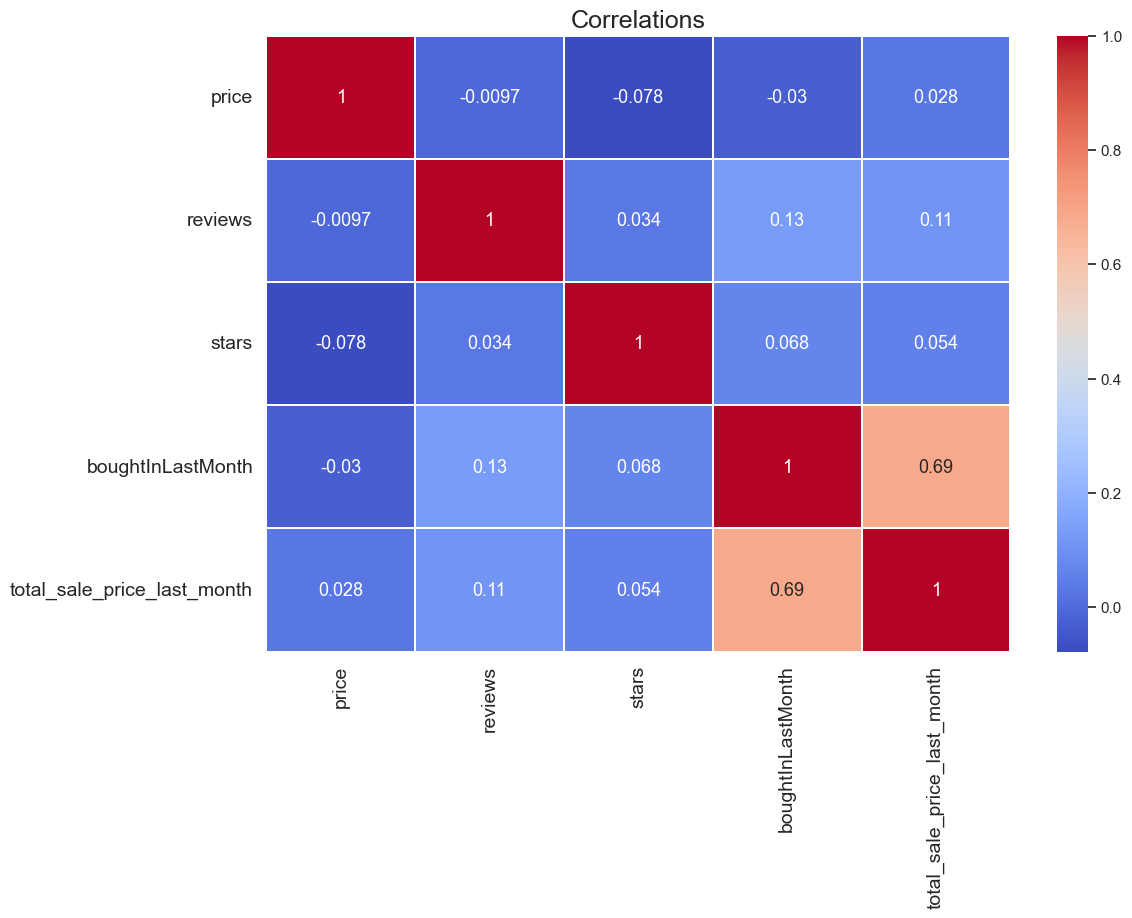

In [25]:
annot_font = {'size': 13}
plt.subplots(figsize=(12, 8))
columns_of_interest = ['price', 'reviews', 'stars', 'boughtInLastMonth', 'total_sale_price_last_month']
corr_matrix = raw_df[columns_of_interest].corr()

sns.heatmap(corr_matrix, linewidths=.2, annot=True, annot_kws=annot_font, cmap='coolwarm')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Correlations', fontsize=18)
plt.savefig("important_correlations_plot.png", bbox_inches="tight")
plt.show()


Price vs. Reviews: There is a very weak negative correlation between price and reviews. This suggests that, on average, items with higher prices might have slightly fewer reviews.

Price vs. Stars: There is a weak negative correlation between price and stars. This suggests that, on average, items with higher prices might have slightly lower star ratings.

Reviews vs. Stars: There is a very weak positive correlation between reviews and stars. This suggests that, on average, items with more reviews might have slightly higher star ratings.

BoughtInLastMonth vs. Other Features: There is a weak negative correlation between 'BoughtInLastMonth' and both 'Price' and 'Reviews', which might indicate that items bought more frequently have slightly lower prices and fewer reviews. There is a moderate positive correlation between 'BoughtInLastMonth' and 'Total Sale Price Last Month', suggesting that items bought more frequently contribute more to the total revenue.

Total Sale Price Last Month vs. Other Features: There is a very weak positive correlation between 'Total Sale Price Last Month' and both 'Reviews' and 'Stars', suggesting that items generating more revenue might have slightly more reviews and higher star ratings.

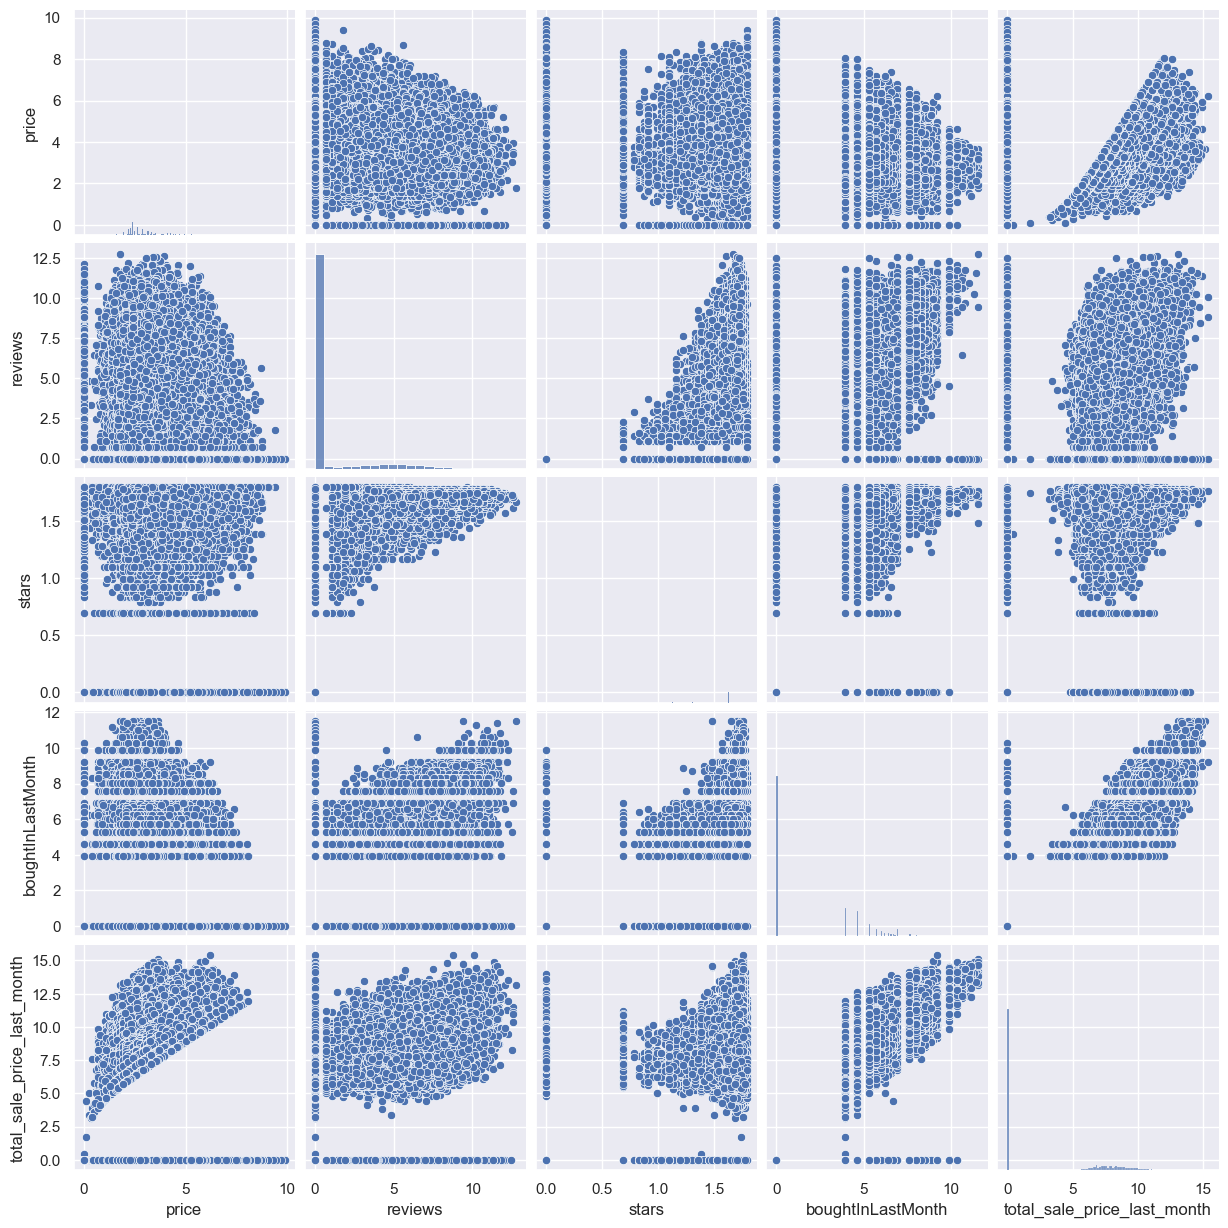

In [26]:
# Just for practice
raw_df['total_sale_price_last_month'] = raw_df['price'] * raw_df['boughtInLastMonth']

# Pairplot with log scale for 'total_sale_price_last_month'
sns.pairplot(raw_df[['price', 'reviews', 'stars', 'boughtInLastMonth', 'total_sale_price_last_month']].apply(lambda x: np.log1p(x)))
plt.show()


(array([1.41145e+05, 0.00000e+00, 4.96900e+03, 7.13000e+02, 3.99000e+03,
        7.45800e+03, 3.09870e+04, 1.09771e+05, 5.43425e+05, 8.92956e+05]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

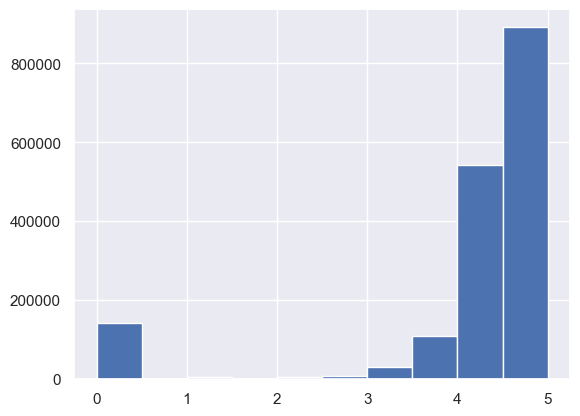

In [27]:
plt.hist(raw_df["stars"])

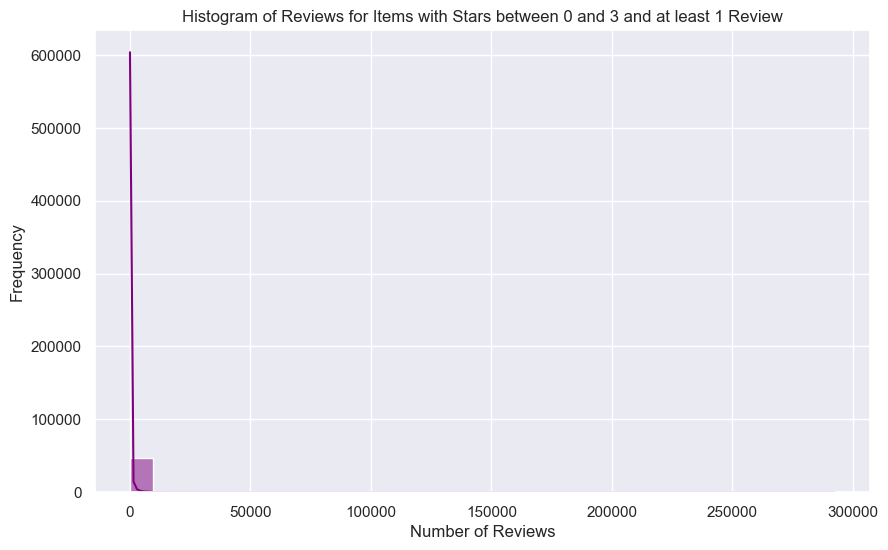

In [28]:
# for curiosity
filtered_df = raw_df[(raw_df['stars'] >= 0) & (raw_df['stars'] <= 4) & (raw_df['reviews'] >= 1)]


plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['reviews'], bins=30, kde=True, color='purple')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('Histogram of Reviews for Items with Stars between 0 and 3 and at least 1 Review')
plt.show()


In [29]:
#only 1-2% of buyers leave a review is a general observation based on the behavior of online shoppers
#So if we multiply the reviews for a product by 50x, then we would get a good understanding how many units has sold.

raw_df['estimated_sales'] = 0  

raw_df['estimated_sales'] = np.where(
    (raw_df['stars'] >= 0) & (raw_df['stars'] <= 4) & (raw_df['reviews'] >= 1),
    (raw_df['reviews'] + 1) * 20,
    (raw_df['reviews'] + 1) * 50
)


In [30]:

raw_df['estimated_revenue'] = (raw_df['estimated_sales'] + raw_df['boughtInLastMonth']) * raw_df['price']


In [31]:
raw_df.columns

Index(['asin', 'title', 'stars', 'reviews', 'price', 'category',
       'isBestSeller', 'boughtInLastMonth', 'has_reviews', 'median_price',
       'total_sale_price_last_month', 'estimated_sales', 'estimated_revenue'],
      dtype='object')

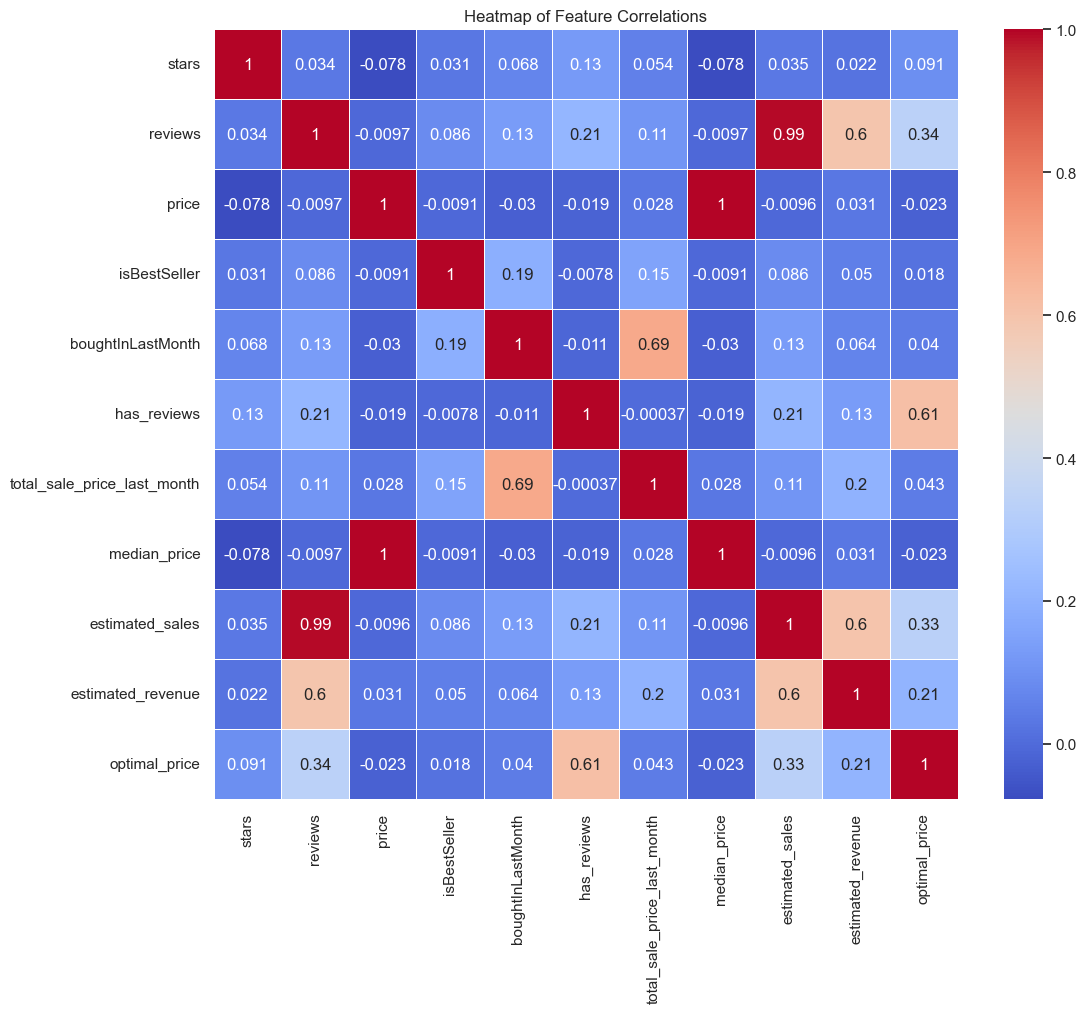

In [33]:
raw_df['optimal_price'] = np.where(raw_df['reviews'] > 200, 1, 0)
heatmap_features = [
    'stars', 'reviews', 'price', 'isBestSeller', 'boughtInLastMonth',
    'has_reviews', 'total_sale_price_last_month', 'median_price',
    'estimated_sales', 'estimated_revenue', 'optimal_price'
]

correlation_matrix = raw_df[heatmap_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Feature Correlations')
plt.show()
